# <font color="#5fa8d3"> Claim Costs

## <font color="#62b6cb"> Table of Content <a name="ToC"></a>
0. [Libraries Importation & Funtions Definition](#id0)<br>
1. [Syntetic Dataset](#id1)<br>
    1.1 [Repair Cost](#id11)<br>
    1.2 [Labour Cost](#id12)<br>
    1.3 [Total Cost Dataset](#id13)<br>
2. [Cost Model](#id2)<br>

## <font color="#62b6cb"> 0. Libraries Importation & Funtions Definition <a name="id0"></a>

In [31]:
import json # to import jsons
import pandas as pd # to manipulate datasets
import numpy as np # to perform numerical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting nicer
from scipy.stats import gamma

## <font color="#62b6cb"> 1. Synthetic Dataset <a name="id1"></a>

First we check again the claim classes that exist:

In [3]:
# Load the JSON data from the file
with open('./archive/train.json') as f:
    data = json.load(f)

# Initialize a set to hold unique classes
unique_classes = set()

# Iterate through the items in the JSON data
for item in data.values():
    # Iterate through each region in the item's regions
    for region in item['regions']:
        # Add the class to the set
        unique_classes.add(region['class'])

# Print the unique classes
print("Unique classes:", unique_classes)

Unique classes: {'tray_son', 'mat_bo_phan', 'vo_kinh', 'mop_lom', 'be_den', 'rach', 'thung'}


**Classes explanation**

* mat_bo_phan=lost parts (Miscellaneous Damage)
* rach=torn (Metal damage tear)
* mop_lom=dented (Metal damage dent)
* tray_son=paint scratches (Metal damage scratches)
* thung=puncture (Miscellaneous Damage)
* vo_kinh=broken glass (Glass damage crack)
* be_den= broken lamp (Miscellaneous Damage)

To do this synthetic dataset we will just focus on the top 2 most popular car brands currently in Ireland by this [webpage](https://www.cso.ie/en/releasesandpublications/ep/p-ieu50/irelandandtheeuat50/society/carmakes/): Toyota and Volkswagen.

Besides to simplify it we will take just the main top 3 sales car models (not considering electric cars) of each one assuming that for each one the  repair cost distribution would change based on price of the model. 

For Toyota the [top3](https://www.toyota.ie/company/news/2023/irelands-best-selling-car-brand) models will be (ordered from [cheaper to more expensive](https://www.toyota.ie/)): Yaris (25k), Corolla (34k) and C-HR(41k). Therefore, Yaris a 25% cheaper and C-HR a 20% more expensive than Corolla.

For Volkswagen the [top3](https://www.cartell.ie/2022/06/most-popular-cars-in-ireland-in-2022/) models will be (ordered [from cheaper to more expensive](https://www.volkswagen.ie/en/new-cars.html)): Polo (24k), Golf (33k) and Tiguan (48k).  Therefore, Polo a 27% cheaper and Tiguan a 45% more expensive than Golf.

In general Toyota cars are [cheaper](https://caredge.com/ranks/maintenance) to repair than Volkswagen for car models of the same class as it is estimated that in 10 year maintenance cost it will be 6k vs 8k so a 25% cheaper.

Lastly we will consider the that cars have 3 different car age ranges. As the average age is [9 years](https://www.simi.ie/en/environment/drive-greener/national-vehicle-fleet) we will assume the following ranges: Newer vehicles [0 years to 7 years], middle age vehicles [7 years to 10 years] and old vehicles [more than 10 years].

The repair costs usually increases over time at an average rate in [doubling](https://www.oponeo.co.uk/blog/how-expensive-are-car-repairs-over-time) every 5 years. If we take the averages of the ranges and the middle age vehicle range as the base, then from 8.5 to 3.5 there is a distance of 5 years so the cost for newer cars will be half and from 8.5 to 12.5 ($(15+10)/2$) is a distance of 4 years so the cost will be 80% higher.

As such, we will create $2 \times 3 \times 3 \times 7 = 126$ different repair cost model.

### <font color="#62b6cb">1.1. Repair Cost</font> <a name="id11"></a>

We will create each of the different damage types datasets.

We create the truncated gamma function:

In [25]:
def truncated_gamma(shape, scale, lower, upper, size):
    samples = []
    while len(samples) < size:
        sample = gamma(shape, scale=scale).rvs(size)
        sample = sample[(sample >= lower) & (sample <= upper)]
        samples.extend(sample)
    return np.array(samples[:size])

**Glass damage crack (vo_kinh)**

For defining the repairs costs distribution of this damage type, we have looked into the following webpages:
* [airtasker](https://www.airtasker.com/ie/costs/windscreen-repair-replacement/cost-of-windscreen-repairs-and-replacement/)

In [169]:
def simulate_data(n=5000, damage_type="glass_crack",low_trunc=100,high_trunc=400,
                  brands={"Toyota": 1}, 
                  models={"Yaris": 0.75, "Corolla": 1, "C-HR": 1.20},
                  model_effect=1,
                  age_effect=1):
    gamma_shape_base = 1.5
    gamma_scale_base = 100
    
    df_combined = pd.DataFrame()
    
    for brand, brand_multiplier in brands.items():
        for model, model_multiplier in models.items():
            
            # Lower age case
            veh_age_lower = np.random.randint(0, 8, size=n)  # 0 to 7
            cost_lower = truncated_gamma(
                gamma_shape_base, gamma_scale_base *1.8 * model_multiplier * brand_multiplier*model_effect,               low_trunc* model_multiplier *model_effect * brand_multiplier*1.8*age_effect,
                high_trunc* model_multiplier *model_effect * brand_multiplier*1.8*age_effect,
                n)
            
            # Base case
            veh_age_base = np.random.randint(7, 11, size=n)  # 7 to 10
            cost_base = truncated_gamma(
                gamma_shape_base, gamma_scale_base *1 * model_multiplier * brand_multiplier*model_effect,               low_trunc* model_multiplier *model_effect * brand_multiplier*1,
                high_trunc* model_multiplier *model_effect * brand_multiplier*1,
                n)
            
            # Higher age case
            veh_age_higher = np.random.randint(10, 16, size=n)  # 10 to 15
            cost_higher = truncated_gamma(
                gamma_shape_base, gamma_scale_base *0.5 * model_multiplier * brand_multiplier*model_effect,               low_trunc* model_multiplier *model_effect * brand_multiplier*0.5*age_effect,
                high_trunc* model_multiplier *model_effect * brand_multiplier*0.5*age_effect,
                n)
            
            # Create DataFrames
            df_lower = pd.DataFrame({
                "brand": [brand] * n,
                "model": [model] * n,
                "veh_age": veh_age_lower,
                "veh_age_range": "Newer",
                "damage_type": [damage_type] * n,
                "cost": cost_lower
            })

            df_base = pd.DataFrame({
                "brand": [brand] * n,
                "model": [model] * n,
                "veh_age": veh_age_base,
                "veh_age_range": "Middle",
                "damage_type": [damage_type] * n,
                "cost": cost_base
            })
        
            df_higher = pd.DataFrame({
                "brand": [brand] * n,
                "model": [model] * n,
                "veh_age": veh_age_higher,
                "veh_age_range": "Old",
                "damage_type": [damage_type] * n,
                "cost": cost_higher
            })
            
            # Combine DataFrames for the current model
            df_model_combined = pd.concat([df_lower, df_base, df_higher], ignore_index=True)
            df_combined = pd.concat([df_combined, df_model_combined], ignore_index=True)
    
    # Shuffle the combined DataFrame
    df_combined = df_combined.sample(frac=1).reset_index(drop=True)
    
    return df_combined

In [178]:
brands = {"Toyota": 1}
models = {"Yaris": 0.75, "Corolla": 1, "C-HR": 1.20}
age=["Newer","Middle","Old"]
df_combined = simulate_data(n=5000, damage_type="glass_crack",low_trunc=100,high_trunc=400,
                            brands=brands, models=models,model_effect=1.4,age_effect=0.7)

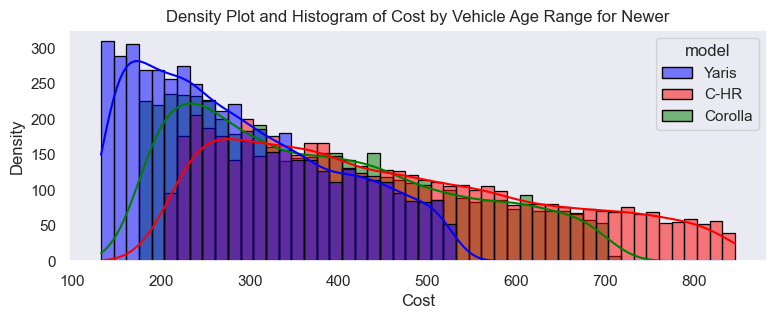

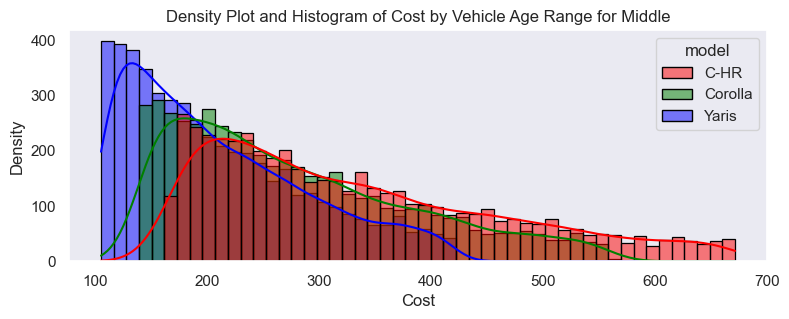

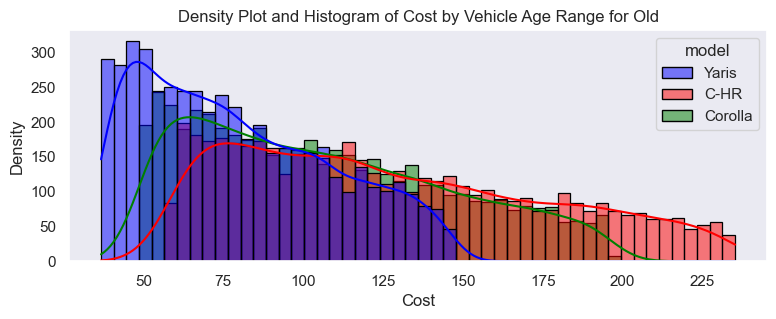

Summary statistics for Yaris:
                 mean     std     min     25%     50%     75%     max
veh_age_range                                                        
Newer          284.09  106.92  132.32  193.30  263.92  362.36  529.13
Middle         207.71   79.69  105.02  141.89  188.84  259.42  419.42
Old             79.17   29.60   36.76   53.55   74.12  101.64  146.92


Summary statistics for Corolla:
                 mean     std     min     25%     50%     75%     max
veh_age_range                                                        
Newer          378.63  144.29  176.45  253.38  355.40  484.40  705.59
Middle         277.13  105.18  140.04  190.97  252.03  344.38  559.59
Old            106.14   39.63   49.02   71.76  100.39  135.12  195.83


Summary statistics for C-HR:
                 mean     std     min     25%     50%     75%     max
veh_age_range                                                        
Newer          457.43  172.62  211.84  309.10  426.69  584.16  84

In [179]:
# Set the dark theme
sns.set_theme(style="dark")

# Define a custom color palette
# palette = {
#     "Newer": "blue",
 #    "Middle": "green",
 #    "Old": "red"
# }

palette = {
    "Yaris": "blue",
    "Corolla": "green",
    "C-HR": "red"
}

# Plot density of cost with histogram by veh_age_range for each model
ordered_models = sorted(models.items(), key=lambda item: item[1])

#for model, _ in ordered_models:
for age_type in age:
    plt.figure(figsize=(9, 3))
    #sns.histplot(df_combined[df_combined['model'] == model], x="cost", hue="veh_age_range", bins=50, kde=True, edgecolor='black', palette=palette)
    sns.histplot(df_combined[df_combined['veh_age_range'] == age_type], x="cost", hue="model", bins=50, kde=True, edgecolor='black', palette=palette)
    plt.title(f'Density Plot and Histogram of Cost by Vehicle Age Range for {age_type}')
    plt.xlabel('Cost')
    plt.ylabel('Density')
    plt.show()


# Summary statistics of cost by veh_age_range and model
summary_stats = df_combined.groupby(['veh_age_range', 'model'])['cost'].describe().drop(columns='count').map(lambda x: f"{x:.2f}")

# Reorder the index based on the desired order
summary_stats = summary_stats.reindex(["Newer","Middle","Old"], level=0)

# Print the formatted and ordered summary statistics for each model
for model in ordered_models:
    print(f'Summary statistics for {model[0]}:')
    print(summary_stats.xs(model[0], level=1))
    print("\n")
   

### <font color="#62b6cb">1.2. Labour Cost</font> <a name="id12"></a>

### <font color="#62b6cb">1.3. Total Cost </font> <a name="id13"></a>

## <font color="#62b6cb"> 2. Cost Model <a name="id2"></a>